In [1]:
import pandas as pd
import os
from PIL import Image, ImageDraw
import pytesseract
import numpy as np
import sys
from tqdm import tqdm
import math

In [83]:
df = pd.DataFrame(columns=["Cat Number", "Site Number", "Locality", "Site", "Name", "Situation"])

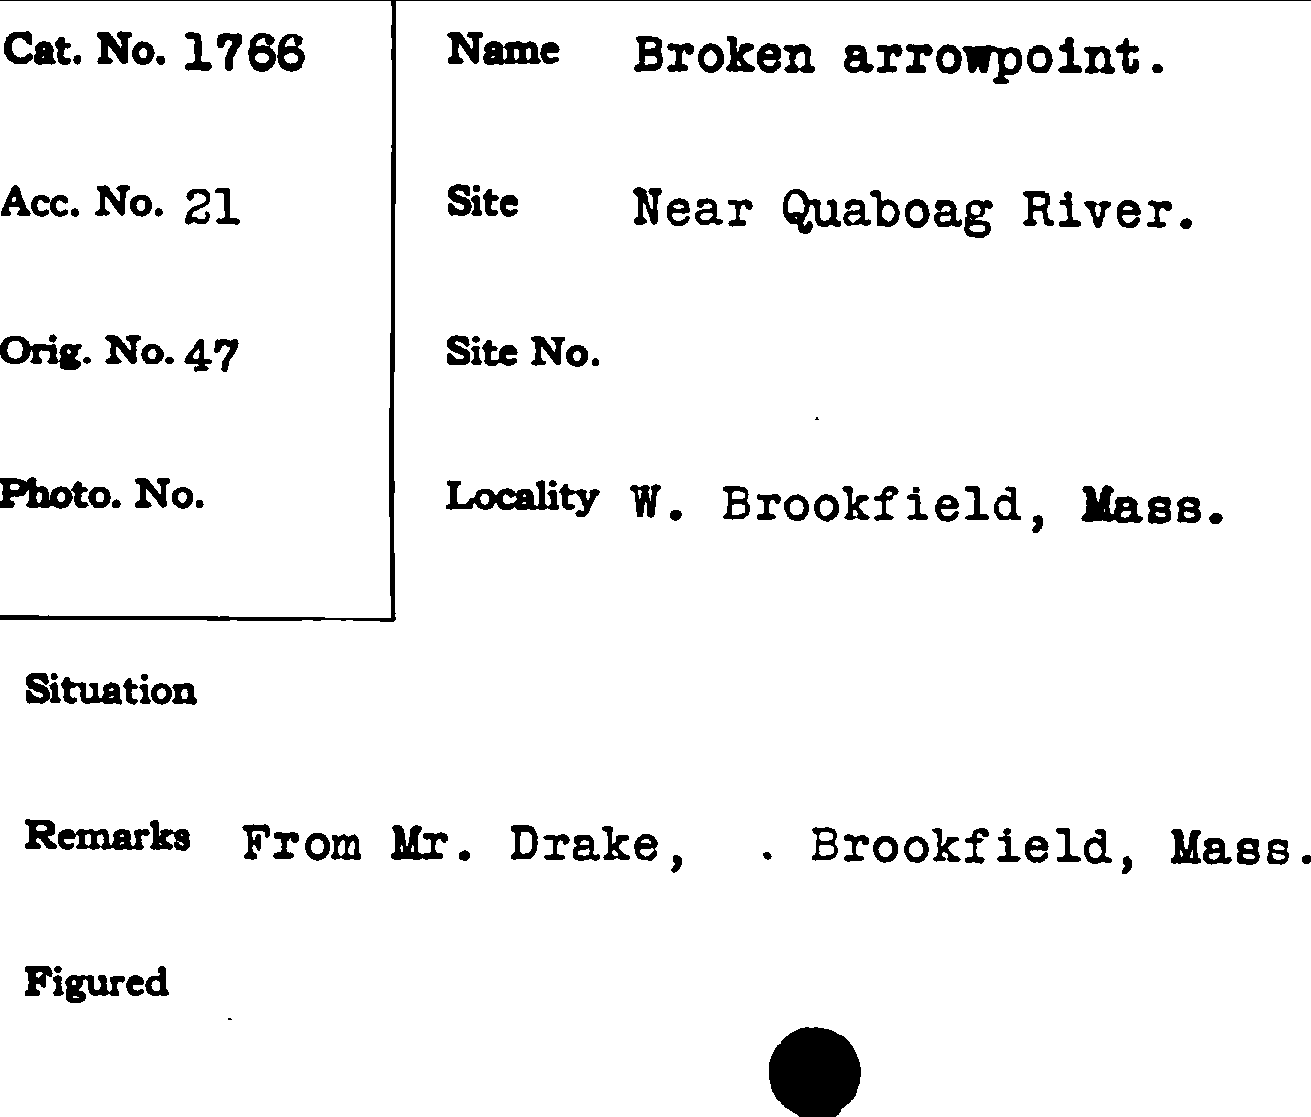

In [101]:
def bestLine(image, bMin,bMax, mMin, mMax, mStep=-1):
    if mStep == -1:
        mStep = (mMax-mMin)/20
    maxScore = 0
    maxB = -1
    maxM = -1
    for b in range(bMin, bMax, 3):
        for m in np.arange(mMin, mMax, mStep):
            score = 0
            momentum = 1
            for x in range(0, image.size[0]):
                y = int(m*x+b)
                if y > image.size[1] or x > image.size[0] or y < 1 or x < 1:
                    continue
                if image.getpixel((x, y)) == 0:
                    score += momentum
                    momentum += 1
                else:
                    momentum = 0
                    score -= 1
            if score > maxScore:
                maxScore = score
                maxB = b
                maxM = m
    if maxM == -1 or maxM == -1:
        print("ERROR")
        sys.exit()
    return maxB, maxM

##I"M SORRY FOR THE CODE REUSE!!!!!!

def cropLeft(bw):
    xSize=bw.size[0]
    ySize=bw.size[1]
    tol=20
    # Crop left
    for x in range(0, int(xSize/10)):
        pixSum = 0
        for y in range(0, ySize):
#             print(bw.getpixel((x, y)))
            if bw.getpixel((x, y)) == 0:
                pixSum += 1
            if pixSum > tol:
                return bw.crop((x, 0, xSize, ySize))
            
def cropRight(bw):
    xSize=bw.size[0]
    ySize=bw.size[1]
    tol=3
    # Crop Right
    for x in range(xSize-1, int(5*xSize/10), -1):
        pixSum = 0
        for y in range(0, ySize):
#             print(bw.getpixel((x, y)))
            if bw.getpixel((x, y)) == 0:
                pixSum += 1
            if pixSum > tol:
                return bw.crop((0, 0, x, ySize))
            
def cropTop(bw):
    xSize=bw.size[0]
    ySize=bw.size[1]
    tol=20
    # Crop left
    for y in range(0, int(ySize/10)):
        pixSum = 0
        for x in range(0, xSize):
            if bw.getpixel((x, y)) == 0:
                pixSum += 1
            if pixSum > tol:
                return bw.crop((0, y, xSize, ySize))
            
def cropBottom(bw):
    xSize=bw.size[0]
    ySize=bw.size[1]
    tol=20
    # Crop left
    for y in range(ySize-1, int(9*ySize/10), -1):
        pixSum = 0
        for x in range(0, xSize):
            if bw.getpixel((x, y)) == 0:
                pixSum += 1
            if pixSum > tol:
                return bw.crop((0, 0, xSize, y))
def rectifyImage(image):
    gray = image.convert('L')
    xSize=image.size[0]
    ySize=image.size[1]
    #Convert to black and white
    bw = gray.point(lambda x: 0 if x<200 else 255, '1')
    # Rotate image
    b, m = bestLine(bw, 500, 700, -.05, .05)
    deg = math.degrees(math.sin(abs(m*xSize)/xSize))
    bw = bw.rotate(-deg, expand=True)
    # Crop sides
    bw = cropLeft(bw)
    bw = cropRight(bw)
    bw = cropTop(bw)
    bw = cropBottom(bw)
    return bw
    

rectifyImage(Image.open("/Users/localhost/Desktop/Projects/Working/PeabodyNotecards/peabody_files/Accession Files/12/21_1766.pdf.png"))

In [102]:
images = []
i = 0
for folder in os.listdir("peabody_files/Accession Files/"):
    if '.DS_Store' in folder:
        continue
    Image.open("peabody_files/Accession Files/"+folder+"/"+list(os.listdir("peabody_files/Accession Files/"+folder))[1]).show()
    site_no=input("Please enter site number: ")
    for file in os.listdir("peabody_files/Accession Files/"+folder):
        if 'DS_Store' in file:
            continue
        print(str(''.join(['-' for x in range(10)])), '\n')
        print("File", "peabody_files/Accession Files/"+folder+'/'+file)
        img = Image.open("peabody_files/Accession Files/"+folder+'/'+file)
        img = rectifyImage(img)
        xSize=img.size[0]
        ySize=img.size[1]
        catNumberImg = img.crop((0, 0, 350, 100))
        localityImg = img.crop((450, 400, xSize-450, 640))
        siteImg = img.crop((440,150, xSize-440, 250))
        nameImg = img.crop((440,5, xSize-440, 100))
        situationImg = img.crop((25,635, xSize-25, 735))

        catNumber = pytesseract.image_to_string(catNumberImg)
        locality = pytesseract.image_to_string(localityImg)
        site = pytesseract.image_to_string(siteImg)
        situation = pytesseract.image_to_string(situationImg)
        name = pytesseract.image_to_string(nameImg)
        print("Cat Number:", catNumber)
        print("Site Number:", site_no)
        print("Locality:", locality)
        print("Site:", site)
        print("Name:", name)
        print("Situation:", situation)
        df.loc[len(df)]=[catNumber, site_no, locality, site, name, situation]

Please enter site number: M50/1
---------- 

File peabody_files/Accession Files/1/1_0001.pdf.png
Cat Number: Cat. No. 1
Site Number: M50/1
Locality: Locality Squibnocket Head, so
Martha' 3 Vineyard, M
Site: Site Squibnocket Cliff .
Name: Name Butt of arrowhead.
Situation: Situation on sand under shell just south of stake 1.
---------- 

File peabody_files/Accession Files/1/1_0002.pdf.png
Cat Number: Cat. No. 2
Site Number: M50/1
Locality: Lmnmw Squibnocket Head, so
Martha's Vineyard, M
Site: Site Squibnocket Cliff.
Name: Name Butt of quartz knife.
Situation: Situation Black sandy loam near stake 2.
---------- 

File peabody_files/Accession Files/1/1_0003.pdf.png
Cat Number: | Cat. No. 3
Site Number: M50/1
Locality: Locality Squibnocket Head, sou
Martha' 3 Vineyard, Ma
Site: Site Squibnocket Cliff .
Name: Name Crude quartz point.
Situation: Situation Black sandy loam, 1M. east of stake A.
---------- 

File peabody_files/Accession Files/1/1_0004.pdf.png
Cat Number: Cat. No. 4
Site Number

In [103]:
df.to_csv("test.csv")